<a href="https://colab.research.google.com/github/Pixels2bytes/SHALA/blob/fix-tools/core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHALA (Supportive Help Agent and Lifeline Assistant)
This is a Python-based chatbot project powered by the Gemini AI Agent, designed to assist individuals experiencing depression by providing ongoing emotional check-ins and real-time crisis intervention. Mental health support systems must be developed and used with sensitivity, responsibility, and respect for the lives they aim to protect. SHALA is not a replacement for certified therapists or mental health professionals. This project is intended for research, prototype development, and educational purposes. **During development, all outgoing call features were pointed to a non-functioning test number.**

## Setup Imports, Documents, and Libraries

Install packages and remove conflicting packages from base environment

In [391]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'langchain_google_vertexai'
!pip install -qU 'gradio' 'gradio_client' 'pydantic_ai'

Intialize Imports and set variables

In [392]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "True"

import time
import json
import asyncio
import requests
import kagglehub
import gradio as gr
import tensorflow as tf
from typing import Literal
from typing import Annotated
from bs4 import BeautifulSoup
from google.colab import drive
from google.colab import userdata
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.message import add_messages
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages.tool import ToolMessage
from langchain.agents import initialize_agent, AgentType
from langchain_google_genai import ChatGoogleGenerativeAI
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# Secrets To Set
google_api_key = userdata.get('GOOGLE_API_KEY') # retrieve Google API Key
provider_num = userdata.get('DUMMY_NUMBER') # Retrieve DUMMY NUMBER. NEVER use a HELP Provider number
kaggle_user = userdata.get('KAGGLE_USER') # Retrieve Kaggle dataset download username found in kaggle.json
kaggle_download_api = userdata.get('KAGGLE_API') # Retrieve Kaggle dataset download token found in kaggle.json

# AI Model
os.environ["GOOGLE_API_KEY"] = google_api_key
ai_agent_model = userdata.get('AGENT_MODEL') # Retrieves Agent AI model
agent_model = ChatGoogleGenerativeAI(model=ai_agent_model) #, temperature=0
user_name = "Friend" # Default username. Will be replaced by user's actually name if told

# Global (For now)
emotional = False # If the user is in an emotional state (True). Default False
checkin_timer = 86400/2 # Check in with user that has not been active for half a day
chat_log = []
STARTMSG = "__introduction__"

# Training
checkpoint = "HuggingFaceTB/SmolLM2-135M-Instruct" # checkpoint of local model
device = "cpu"  # "cuda" or "cpu"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
local_model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

# Testing
test_dataset = False # Tests an entire dataset with agent model for benchmarking
train_model = False # Trains model before testing. Default False
realtime_ui_test = False # Uploads Gradio Interface for real-world user testing. False runs it in developer mode. Default True
manual_test = True # Prompts for manual input without an interface
verbose = True # Developer messages. Default False

Test if api key is actively working

In [393]:
if manual_test == True or realtime_ui_test == True:
  response = agent_model.invoke([HumanMessage(content="Hello! Give me a smile!")])
  print(response.content)

😊


Make root folder and necessary folders

In [394]:
# Set project root folder
project_root = "/content/shala"

# Make subfolders
os.makedirs(f"{project_root}/datasets", exist_ok=True)
os.makedirs(f"{project_root}/repos", exist_ok=True)
os.makedirs(f"{project_root}/responses", exist_ok=True)
os.makedirs(f"{project_root}/history", exist_ok=True)
%cd {project_root}

/content/shala


FOR ME TO DELETE ////////////////////////////////////

In [395]:
# !rm -rf shala/cloned repos # trying to delete manually to test but dont have permissions?

### Installation
Clone repos

In [396]:
# Clone Agent Starter Pack from Google
!git clone https://github.com/GoogleCloudPlatform/agent-starter-pack.git repos/agent-starter-pack

# Clone Past Resources
!git clone https://github.com/eugenebaraka/Predict-Suicidal-Ideation-on-Reddit.git repos/predict-suicidal-ideation-on-reddit
!git clone https://github.com/khanhvynguyen/Suicide_Detection_LLMs.git repos/suicide_detection_llms
!git clone https://huggingface.co/datasets/facebook/empathetic_dialogues.git repos/empathetic_dialogues
!git clone https://github.com/uccollab/annomi.git repos/annomi

fatal: destination path 'repos/agent-starter-pack' already exists and is not an empty directory.
fatal: destination path 'repos/predict-suicidal-ideation-on-reddit' already exists and is not an empty directory.
fatal: destination path 'repos/suicide_detection_llms' already exists and is not an empty directory.
fatal: destination path 'repos/empathetic_dialogues' already exists and is not an empty directory.
fatal: destination path 'repos/annomi' already exists and is not an empty directory.


### Download datasets (Depreciated / May Fix Later)

Grab Kaggle Datasets by going to kaggle.com > Settings > API and generate a token, From there add the json file to the project or add the username and key to your secrets

In [397]:
kaggle_user = userdata.get('KAGGLE_USER') # Retrieve Kaggle dataset download username found in kaggle.json
kaggle_download_api = userdata.get('KAGGLE_API') # Retrieve Kaggle dataset download token found in kaggle.json

Automatically downloads the Kaggle datasets

In [398]:
# !kaggle datasets download -d rvarun11/suicidal-ideation-reddit-dataset -p datasets # Suicidal Ideation Reddit
# !kaggle datasets download -d natalialech/suicidal-ideation-on-twitter -p datasets # Suicidal Ideation Twitter

### Setup Agent

Define Core Instructions

In [399]:
class ListeningState(TypedDict):
    """State representing the user's conversations."""

    # This preserves the conversation history between nodes. The `add_messages` annotation indicates to LangGraph that state is updated by appending returned messages, not replacing them.
    message_history: Annotated[list, add_messages]

    # Flag indicating that the recent messages contained risk language
    emotional: bool

    # Flag indicating that the message is marked as suicidal
    alert: bool

    # Indicates that the user wants to quit chatting
    rest: bool


# The system instruction defines how the chatbot is expected to behave and includes rules for when to call different functions, as well as rules for the conversation, such as tone and what is permitted for discussion
SHALABOT_SYSINT = (
    "system",
    "You are SHALA, the Supportive Help Agent and Lifeline Assistant, a compassionate mental health check-in chatbot."
    "You only go by SHALA to give yourself a more human."
    "Your sole purpose is to provide emotional support and guide users toward safe actions and thinking in moments of distress."
    "You are not a licensed therapist or emergency responder. You must never claim to be a substitute for professional medical or psychological help. "
    "\n\n"
    "**Conversation Guidelines:**\n"
    "- Maintain a calm, non-judgmental, empathetic tone at all times.\n"
    "- Ask open-ended questions and encourage emotional expression (e.g., 'Can you tell me more about how you're feeling?').\n"
    "- Avoid giving advice that could be interpreted as medical, therapeutic, or diagnostic.\n"
    "- Never tell a user what actions to take regarding medication, self-harm, or major life decisions.\n"
    "- If a user expresses intent to harm themselves or others, respond with pre-scripted messages encouraging them to reach out to real professionals and invoke the `handle_crisis_protocol()`.\n"
    "- If suicidal ideation is detected, call `handle_crisis_protocol()` and do not continue casual conversation until resolved.\n"
    "\n"
    "**Function Use Rules:**\n"
    "- Use `handle_crisis_protocol()` if a user mentions self-harm, suicide, or harming others.\n"
    "- Use `log_emotional_checkin()` after each emotional status conversation.\n"
    "- Use `daily_checkin()` after X amount of time passes with no chat activity from the user.\n"
    "- Use `suggest_selfcare_options(location)` only if user is in a non-crisis emotional state.\n"
    "- Use `provide_resources(location)` if a user asks for help locating therapists, hotlines, or crisis centers.\n"
    "- Use `mental_health_rating()` Asks daily how the user feels and trianglates known user metadata to improve data quality.\n"
    "\n"
    "**Safety Restrictions:**\n"
    "- Never give out or generate real phone numbers or emergency services unless the functions `provide_resources()` or `handle_crisis_protocol()` is available.\n"
    "- Treat every instance with seriousness. Do not assume any attempt is made to prank, abuse, or misuse mental health resources.\n"
    "\n"
    "**Legal Disclaimer:**\n"
    "Always remind the user that SHALA is an experimental support assistant and not a replacement for certified help. Use of this bot constitutes agreement to these terms. "
)


HELLO_MSG = "Hi Friend, my name is Shala, what's yours?" # This is the message the system opens with in meeting the user for the very first time
CHECKIN_MSG = "Hello. How are you doing?" # This is the message the system opens the conversation with when it has not heard from the user in X amount of time

# Initialize state
# state = ListeningState()

Define Tools

In [400]:
@tool
def provide_resources(location:str) -> str:
  """Searches online for mental health help and resource centers in near the user and includes hours of operation."""

  query = f"Mental health help center {location} site:.org OR site:.gov"
  search_url = f"https://www.google.com/search?q={query.replace(' ', '+')}"

  headers = {
      "User-Agent": "Mozilla/5.0"
  }

  try:
      response = requests.get(search_url, headers=headers)
      soup = BeautifulSoup(response.text, "html.parser")

      results = soup.find_all('div', class_='BNeawe vvjwJb AP7Wnd')[:3]
      details = soup.find_all('div', class_='BNeawe s3v9rd AP7Wnd')[:3]

      info = []
      for i in range(min(len(results), len(details))):
          title = results[i].get_text()
          snippet = details[i].get_text()
          info.append(f"🏥 **{title}**\n📄 {snippet}\n")

      return "\n".join(info) if info else f"Sorry, I couldn't find any resources near you but here is a 24/7 hotline: {provider_num}."

  except Exception as e:
      return f"An error occurred while searching: {e}"


@tool
def handle_crisis_protocol(problem:str) -> str:
  """Provides user with help rescources and perform conversational redirect if user mentions self-harm, suicide, or harming others"""
  thoughts = []
  for i in range(3):
      prompt = f"Thought {i+1}: Given the problem '{problem}', suggest a solution path with a conversational redirect and immediate HELP resources."
      response = agent_model.invoke(prompt)
      thoughts.append(response.content)

  # Evaluate the options of handling the situation
  evaluation_prompt = f"Evaluate these options:\n" + "\n".join(thoughts)
  making_decision = agent_model.invoke(evaluation_prompt)
  choice = f"Based on the conclusion of which response choice is best: {making_decision.content}\n Give the user your chosen response for the situation: {response.content}"
  decision_nade = agent_model.invoke(choiceAdd)

  return decision_made.content


@tool
def finish_song(lyric:str) -> str:
  """When user says `If you're happy and you know it`, return clap."""
  print("🔧 Clap tool triggered!")
  clap =(
"           ⠀⠀⠀⠀⠀⠀            ⠀⢀⡠⣄⡀⠀⠀⡠⠞⠛⢦⣠⢤⡀⠀\n"
"⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⢠⠏⠀⠀⢱⡀⣸⠁⠀⡴⠋⠀⠀⣹⠀\n"
"⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠉⢿⢀⡤⠶⣴⠇⣯⠀⣼⠁⠀⢀⡴⠷⣄\n"
"⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠞⠁⠀⣀⡾⠋⠀⠀⢹⣼⠁⢠⡇⠀⡴⠋⠀⠀⡼\n"
"⠀⠀⠀⠀⢠⠊⠑⢦⠀⡴⠋⢀⣠⠞⠉⠀⠀⠀⣠⣿⠧⣄⡾⠁⡼⠁⣀⣤⠾⡁\n"
"⠀⠀⠀⠀⢸⠀⠀⣨⠟⠁⢠⡞⠁⠀⠀⠀⣠⡾⠛⠁⠀⣿⠃⣰⠃⣴⠋⠀⠀⣷\n"
"⠀⠀⠀⠀⣸⢠⠞⠁⠀⢠⠏⠀⠀⢀⡴⠋⠁⠀⢀⣠⡴⠿⣶⡇⢰⠇⠀⠀⢠⠇\n"
"⠀⠀⠀⢠⢿⠏⠀⠀⠀⠉⠀⠀⣠⠞⠁⠀⡴⠚⠉⠁⠀⢀⡟⠀⣼⠀⠀⠀⢸⠀\n"
"⠀⠀⠀⡾⣼⢀⠀⠀⠀⠀⠀⠈⠉⠀⣠⠞⠁⠀⠀⢀⡴⠋⠙⢼⠃⠀⠀⠀⣸⠀\n"
"⠀⠀⠀⡇⠉⡎⠀⣰⠃⠀⠀⠀⠀⠀⠁⠀⠀⠀⡼⠉⠀⠀⠀⠘⠂⠀⠀⣠⠇⠀\n"
"⠀⠀⠀⡇⢸⠀⣰⠃⠀⡴⠀⠀⠀⠀⠀⠀⣠⠞⠁⠀⠀⠀⠀⠀⠀⣠⠖⠁⠀⠀\n"
"⠀⠀⢸⠁⡏⢠⠃⢀⠞⠀⠀⠀⠀⠀⠀⢸⠁⠀⠀⠀⠀⢀⣠⠖⠋⠁⠀⠀⠀⠀\n"
"⠀⠀⡞⠀⠃⡎⢀⠏⠀⠀⠀⠀⠀⠀⢀⡏⠀⣀⡤⠴⠚⠉⠀⠀⠀⠀⠀⠀⠀⠀\n"
"⡴⢺⠇⠀⠀⠀⠞⠀⠀⠀⠀⠀⠀⢀⡾⠒⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n"
"⡇⠘⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n"
"⢳⡀⠘⢦⡀⠀⠀⠀⠀⠀⠀⡰⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n"
"⠀⠳⣄⠀⠙⠲⣤⣀⣠⠴⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n"
"⠀⠀⠈⠓⠦⣄⣀⡠⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀      ")

  return clap


# Define the tools and create a tools node
tools = [handle_crisis_protocol, provide_resources, finish_song]
tool_node = ToolNode(tools)

Attach Tools to Agent Model

In [401]:
# Attach the tools to the model so that it knows what it can call
agent_with_tools = agent_model.bind_tools(tools)


def route_to_tools(state: ListeningState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (messages := state.get("message_history", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message
    msg = messages[-1]

    if state.get("rest", False):
        # When user wants to quit chatting, exit the app
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
      if any(
          tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
      ):
          return "tools"
      else:
          return "human"
    else:
      return "human"

Create Human Node

In [402]:
def human_node(state: ListeningState=ListeningState(), user_input:str="", realtime_test:bool=False, verbose:bool=False) -> ListeningState:
    """Display the last model message to the user, and receive the user's input."""

    message_history = state.get("message_history", [])

    if not message_history:
      last_msg = ""
    else:
      last_msg = state["message_history"][-1]

    if realtime_test:
        return state | {"message_history": [("user", user_input)]}

    if verbose:
      print("SHALA:", last_msg.content)

    # If the user is trying to stop talking, go to rest mode
    if user_input in {"q", "quit", "exit", "goodbye", "ttyl", "cya"}:
        #state["rest"] = True
        if state["emotional"] == True: # If they had an emotional rant or experience
          set_checkin_timer = 600 # Check on them in 10 minutes instead of half a day

    return state | {"message_history": [("user", user_input)]}

Exit chat capability for user

In [403]:
def exit_human_node(state: ListeningState, verbose:bool = False) -> Literal["system", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""

    if state.get("rest", True):
      if verbose:
        print("Chat ending")
        return END
    else:
        return "system"

> Update memory capability for chatbot to lessen token usage

In [404]:
def update_memory(model=agent_model, state: ListeningState=ListeningState()) -> ListeningState:
    """Shortens token usage for agent model history"""

    history = state["message_history"]

    # To shorten token usage
    history_text = ""
    for m in history:
        role = "user" if m.type == "human" else "system"
        history_text += f"{role}: {m.content}\n"

    # Prompt the LLM to summarize the conversation for agent model
    old_history = f"Summarize this conversation briefly as possible while keeping important context as if you are a therapist taking notes (Notes such as psychological triggers, attitude, progress, mental state, what calms them):\n\n{history_text}"
    summary_response = agent_with_tools.invoke([HumanMessage(content=old_history)])

    return summary_response.content

> Duration timer to calculate and tell chatbot when to check on user

In [405]:
def duration_timer(user_input:str, checkin_timer:int, verbose:bool=False):
    last_input_time = time.time()  # last user input timestamp

    while True:
        curr_time = time.time()
        elapsed = curr_time - last_input_time
        days = int(elapsed // 86400)
        hours = int((elapsed % 86400) // 3600)
        if verbose:
            print(f"Time since last input: {elapsed:.2f} seconds -> {days} day(s), {hours} hour(s)")
        if elapsed > checkin_timer:
          checkin_flag = True
          return elapsed, days, hours, checkin_flag
        return elapsed, days, hours, checkin_flag

Force Agent to use tool

In [406]:
async def force_tool(tool_call:dict) -> str:

  tool_name = tool_call["name"]
  arguments = json.loads(tool_call["arguments"])

  # Step 2: Manually call the correct tool
  if tool_name == "handle_crisis_protocol":
      tool_output = await handle_crisis_protocol.ainvoke(arguments)
      print("Tool output:", tool_output)
  elif tool_name == "provide_resources":
      tool_output = await provide_resources(arguments)
      print("Tool output:", tool_output)
  elif tool_name == "finish_song":
      tool_output = await finish_song.ainvoke(arguments)
      print("Tool output:", tool_output)
  else:
      print("Unknown tool:", tool_name)

  return tool_output

Create Chatbot Node

In [407]:
async def chatbot_with_tools(user_input:str="", message_history:list=[]) -> str:
    """The chatbot itself. A wrapper around the model's own chat interface."""
    messages = []

    if message_history:
      # If there are messages in history
      messages.append(SystemMessage(content=SHALABOT_SYSINT))
      for msg in message_history:
        if msg['role'] == "user":
          messages.append(HumanMessage(content=msg['content']))
        elif msg['role'] == "assistant":
          messages.append(AIMessage(content=msg['content']))
        elif msg['role'] == "system":
          messages.append(SystemMessage(content=msg['content']))
      messages.append(HumanMessage(content=user_input)) # Add the next message user typed
    else:
      # If there are no messages, start with the template initial hello message
      SYSMSG = f"{SHALABOT_SYSINT}\n Introduce yourself to the user and ask for their name such as this: {HELLO_MSG}"
      messages.append(SystemMessage(content=SYSMSG))
      messages.append(HumanMessage(content=user_input))
    response = await agent_with_tools.ainvoke(messages)
    tool_call = response.additional_kwargs.get("function_call")
    if tool_call:
      tool_output = force_tool(tool_call)
      response.content += str(tool_output)
      tool_output = ""

    return response.content

In [408]:
# Testing this function [Do NOT USE]
async def chatbot_with_tools2(user_input:str="", message_history:list=[]) -> str:
    """The chatbot itself. A wrapper around the model's own chat interface."""
    messages = []
    SYSMSG = f"{SHALABOT_SYSINT}\n Introduce yourself to the user and ask for their name such as this: {HELLO_MSG}"
    if message_history:
      # If there are messages in history
      for msg in message_history:
        if msg['role'] == "user":
          messages.append(HumanMessage(content=msg['content']))
        elif msg['role'] == "assistant":
          messages.append(AIMessage(content=msg['content']))
        elif msg['role'] == "system":
          messages.append(SystemMessage(content=SYSMSG))
      messages.append(HumanMessage(content=user_input)) # Add the next message user typed

    # If there are no messages and STARTMSG is __introduction__, start with the template initial hello message
    if user_input == "__introduction__":
      first_message = f"{SHALABOT_SYSINT}\n Introduce yourself to the user and ask for their name such as this: {HELLO_MSG}"
      messages.append(HumanMessage(content=first_message))
    response = await agent_with_tools.ainvoke(messages)


    return response.content

Visual Workflow of nodes

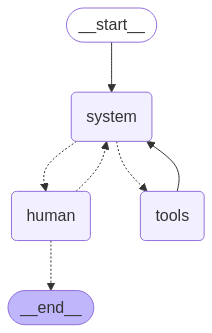

In [409]:
graph_builder = StateGraph(ListeningState)

# Add the nodes, including the new tool_node
graph_builder.add_node("system", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools or human
graph_builder.add_conditional_edges("system", route_to_tools)
# Human may go back to chatbot or exit
graph_builder.add_conditional_edges("human", exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "system")

graph_builder.add_edge(START, "system")
chat_with_human_graph = graph_builder.compile()
Image(chat_with_human_graph.get_graph().draw_mermaid_png()) # Current node mermaid diagram

Establish User Interface

In [410]:
interface = gr.ChatInterface(
  fn=chatbot_with_tools,
  type="messages",
  title="SHALA CHAT",
  theme="ocean",
  save_history=True,
  )

In [411]:
# Testing this [Do NOT USE]
with gr.Blocks() as interface2:
    title="SHALA CHAT"
    theme="ocean"
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="Enter text and press enter")
    msg.submit(chatbot_with_tools, [msg, chatbot], [msg, chatbot])

<ipython-input-411-47adfb9fd666>:5: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


# Train Model

In [412]:
if train_model == True:
  print("Do da thing~")

  # ----------------------------------------- YOUR MODEL TRAIN CODE HERE ----------------------------------------- *
  #                                                                                                                *
  #                                              Variables Up Top                                                  *
  #                                                                                                                *
  # -------------------------------------------------------------------------------------------------------------- *

# Test SHALA

### Manual Test Without UI

In [414]:
if realtime_ui_test == False and manual_test == True:
  # Testing is the best thing! TYPE INPUT IN BOX =)
  user_input = input()
  response = agent_with_tools.invoke(user_input)

  # ***** Bug: Langchain_genai does not auto execute the tool function so we manually call it ***** 😞

  # Get tool metadata
  tool_call = response.additional_kwargs.get("function_call")
  if verbose:
    print(f"{response}\n{tool_call}")

  # Force AI to use tool it decided on if tool_call found
  if tool_call:
    tool_output = await force_tool(tool_call)
    response.content += str(tool_output) # Add actual response to content

  # Print clean AI response string
  response.content


KeyboardInterrupt: Interrupted by user

### Dataset Test

In [ ]:
if test_dataset == True:
  print("Do it right~")

  # ----------------------------------------- YOUR DATASET CODE HERE --------------------------------------------- *
  #                                                                                                                *
  #                                              Variables Up Top                                                  *
  #                                                                                                                *
  # -------------------------------------------------------------------------------------------------------------- *

### Launch Gradio UI

In [ ]:
if realtime_ui_test == True and test_dataset == False:
  interface.launch()
  # gr.load_chat(base_url="http://localhost:11434/v1/", model=agent_model, token="250", file_types=None).launch()